In [278]:
from torchvision.models import resnet50
import numpy as np
import os
import torch
from PIL import Image
from torch.autograd import Variable as V
from torch.nn import functional as F
from torchvision import transforms
import torch

In [227]:
import wideresnet

In [433]:
model = wideresnet.resnet50(num_classes=365)

In [454]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=1)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=1)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=1)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=1)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_st

In [229]:
model_file = 'resnet50_places365.pth.tar'
if not os.access(model_file, os.W_OK):
    os.system('curl http://places2.csail.mit.edu/models_places365/' + model_file + ' --output ' + model_file)
    os.system('curl https://raw.githubusercontent.com/csailvision/places365/master/wideresnet.py' + ' --output wideresnet.py')


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 92.7M  100 92.7M    0     0  2199k      0  0:00:43  0:00:43 --:--:-- 3600k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6691  100  6691    0     0  18848      0 --:--:-- --:--:-- --:--:-- 18847


In [243]:
def recursion_change_bn(module):
    if isinstance(module, torch.nn.BatchNorm2d):
        module.track_running_stats = 1
    else:
        for i, (name, module1) in enumerate(module._modules.items()):
            module1 = recursion_change_bn(module1)
    return module

In [434]:
features_blobs = []
def hook_feature(module, input, output):
    features_blobs.append(np.squeeze(output.data.cpu().numpy()))

In [435]:
checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage)
state_dict = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()}
model.load_state_dict(state_dict)
for i, (name, module) in enumerate(model._modules.items()):
    module = recursion_change_bn(model)
model.avgpool = torch.nn.AvgPool2d(kernel_size=14, stride=1, padding=0)

model.eval()

features_names = ['layer4','avgpool'] # this is the last conv layer of the resnet
for name in features_names:
    model._modules.get(name).register_forward_hook(hook_feature)


In [175]:
classes_url = "https://raw.githubusercontent.com/csailvision/places365/master/categories_places365.txt"
io_places_url = "https://raw.githubusercontent.com/csailvision/places365/master/IO_places365.txt"
file_name_attribute_url = "https://raw.githubusercontent.com/csailvision/places365/master/labels_sunattribute.txt"
w_attribute_url = "http://places2.csail.mit.edu/models_places365/W_sceneattribute_wideresnet18.npy"

In [176]:
# download the class labels
os.system('curl ' + classes_url + ' --output categories_places365.txt')
os.system('curl ' + io_places_url + ' --output IO_places365.txt')
os.system('curl ' + file_name_attribute_url + ' --output labels_sunattribute.txt')
os.system('curl ' + w_attribute_url + ' --output W_sceneattribute_wideresnet18.npy')

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6833  100  6833    0     0  19302      0 --:--:-- --:--:-- --:--:-- 19356
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6214  100  6214    0     0  16733      0 --:--:-- --:--:-- --:--:-- 16704
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   909  100   909    0     0   2238      0 --:--:-- --:--:-- --:--:--  2244
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  408k  100  408k    0     0   108k      0  0:00:03  0:00:03 --:--:--  108k


0

In [246]:
def load_labels():
    with open('categories_places365.txt') as class_file:
        lines = class_file.readlines()
        classes = [line.rstrip() for line in lines]
    
    with open('IO_places365.txt') as io_file:
        lines = io_file.readlines()
        io_classes = [line.rstrip() for line in lines]
        io_classes = [int(i[-1])-1 for i in io_classes]
            
    with open('labels_sunattribute.txt') as attribute_file:
        lines = attribute_file.readlines()
        attributes = [line.rstrip() for line in lines]
            
    w_attribute = np.load('W_sceneattribute_wideresnet18.npy')
    
    return classes, np.array(io_classes), attributes, w_attribute

In [247]:
classes, labels_IO, labels_attribute, W_attribute = load_labels()

In [447]:
def returnTF():
    # load the image transformer
    tf = transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    )
    return tf

In [448]:
tf = returnTF()

In [449]:
img_path = './datasets/people/8EE92C94-CEE4-4D18-9545-DFFE3CFC2667_4_5005_c.jpeg'
img = Image.open(img_path)
input_img = V(tf(img).unsqueeze(0), volatile=True)

/var/folders/xr/2hb2_5hd3w7_wyll20m90fw80000gn/T/ipykernel_21968/1273871136.py:3: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  input_img = V(tf(img).unsqueeze(0), volatile=True)


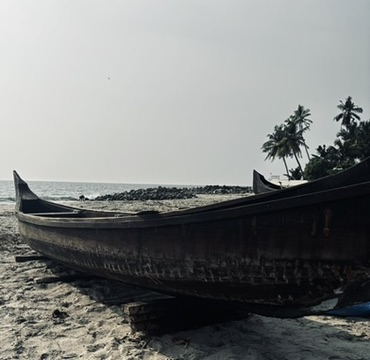

In [450]:
img

In [453]:
logit = model.forward(input_img)
h_x = F.softmax(logit, 1).data.squeeze()
probs, idx = h_x.sort(0, True)
probs = probs.numpy()
idx = idx.numpy()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x18432 and 2048x365)

In [272]:
io_image = np.mean(labels_IO[idx[:10]])
if io_image < 0.5:
    print("--TYPE OF ENVIRONMENT: indoor")
else:
    print("--TYPE OF ENVIRONMENT: outdoor")

--TYPE OF ENVIRONMENT: outdoor


In [268]:
out = []
for i in range(0, 5):
    print('{:.3f} -> {}'.format(probs[i], classes[idx[i]]))
    if i==0 or probs[i]>0.10:
        out.append('%s (%.3f)' % (classes[idx[i]], probs[i]))
print('"scenes": "%s", ' % (', '.join(out)))
print('"topcategory": "%s", ' % (classes[idx[0]]))

0.056 -> /l/lighthouse 214
0.034 -> /d/desert/vegetation 117
0.028 -> /o/ocean 243
0.027 -> /l/landing_deck 207
0.024 -> /r/runway 293
"scenes": "/l/lighthouse 214 (0.056)", 
"topcategory": "/l/lighthouse 214", 


In [220]:
# responses_attribute = W_attribute.dot(features_blobs[1])
# idx_a = np.argsort(responses_attribute)
# out = ', '.join([labels_attribute[idx_a[i]] for i in range(-1,-10,-1)])
# print(out)

In [372]:
from wavemix.classification import WaveMix

In [474]:
model = WaveMix(
    num_classes=365,
    depth=12,
    mult=2,
    ff_channel=256,
    final_dim=256,
    dropout=0.5,
    level=2,
    initial_conv="pachify",
    patch_size=8,
)

url = "https://huggingface.co/cloudwalker/wavemix/resolve/main/Saved_Models_Weights/Places365/places365_54.94.pth"

model.eval()
model.load_state_dict(torch.hub.load_state_dict_from_url(url, map_location="cpu"))


<All keys matched successfully>

In [481]:
img = Image.open("./datasets/people/D35D0AF4-FDAA-4520-8848-6AEEACCEF653_1_105_c.jpeg")


In [482]:
to_tensor_transform = transforms.Compose(
    [
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        ),
    ]
)

In [483]:
img_tensor = to_tensor_transform(img).unsqueeze(0).to("cpu")

In [484]:
with torch.no_grad():
    logits = model(img_tensor)

In [485]:
preds = F.softmax(logits, 1).data.squeeze()
probs, idx = preds.sort(0, True)
probs = probs.numpy()
idx = idx.numpy()

In [486]:
idxout = []
for i in range(0, 5):
    print("{:.3f} -> {}".format(probs[i], classes[idx[i]]))
    if i == 0 or probs[i] > 0.10:
        idxout.append("%s (%.3f)" % (classes[idx[i]], probs[i]))
print('"scenes": "%s", ' % (", ".join(idxout)))
print('"topcategory": "%s", ' % (classes[idx[0]]))

0.222 -> /p/park 254
0.062 -> /b/bamboo_forest 36
0.059 -> /p/parking_lot 257
0.048 -> /d/driveway 127
0.047 -> /t/tree_farm 338
"scenes": "/p/park 254 (0.222)", 
"topcategory": "/p/park 254", 


In [573]:
album_mapping = {
    # Background Spots
    "background is a forest": "In the Heart of Nature",
    "background is a city skyline": "Urban Wonders",
    "background is a mountain": "Peaks and Valleys",
    "background has a sunset": "Golden Horizons",
    "background is a desert": "Desert Dreams",
    "background is a snowy landscape": "Winter Wonderland",
    "background has river": "By the River Side",
    "background is a park": "Day in the Park",
    "background is a beach": "Seaside Serenity",
    "background is an indoor office": "Workspaces",
    "background is a garden": "Garden Bliss",
    "background is a street": "City Streets",
    "background is a stadium": "Stadium Vibes",
    "background is a playground": "Playtime",
    "background has buildings": "Architectural Views",
    "background is a marketplace": "Market Scenes",
    "background is a cafe or restaurant": "Café Moments",
    "background is a library": "In the Library",
    "background is a swimming pool": "Poolside Fun",
    "background is a concert stage": "On the Stage",
    "background is a worship place": "Sacred Spaces",
    "background is a classroom": "Classroom Moments",
    "background is a parking lot": "Parking Spaces",
    "background has a bridge": "Bridging the Gap",
    # Events and Moments
    "day at school": "School Days",
    "sports event": "Game Time",
    "birthday party": "Birthday Celebrations",
    "celebration or party": "Moments of Celebration",
    "casual outdoor gathering": "Outdoor Gatherings",
    "meeting or conference": "Conferences & Meetings",
    "indoor leisure time": "Indoor Relaxation",
    "outdoor adventure": "Adventures Outdoors",
    "rainy day outdoors": "Rainy Day Vibes",
    "morning routine": "Morning Moments",
    "evening relaxation": "Evening Calm",
    "night out": "Nightlife",
    "outdoor festival": "Festival Fun",
    "travel or commute": "Journeys",
    "holiday celebration": "Holiday Joy",
    "leisure by the beach": "Beach Escapes",
    "playing with pets": "Pet Playtime",
    "exercising outdoors": "Outdoor Workouts",
    "working at a desk": "Work Mode",
    "performance on stage": "Performance Spotlight",
    "camping or hiking": "Camping & Trails",
    "visiting a landmark": "Landmark Visits",
    "market or shopping scene": "Market Moments",
    "dining at a restaurant": "Dining Delights",
    "walking in the city": "City Walks",
    "sunset or sunrise moment": "Sunrise & Sunset",
    # Food and Dining
    "breakfast table spread": "Breakfast Bliss",
    "lunch outdoors": "Outdoor Lunch",
    "evening snacks": "Snack Time",
    "coffee or tea time": "Coffee Breaks",
    "dinner setup": "Dinner Time",
    "desserts or sweets": "Sweet Treats",
    "fast food items": "Fast Food Fix",
    "barbecue or grill": "BBQ Moments",
    "buffet or feast": "Buffet Time",
    "picnic food": "Picnic Eats",
    "fresh fruits and vegetables": "Fresh Picks",
    "bakery or pastry display": "Bakery Delights",
    # Animals and Birds
    "dogs": "Dog Days",
    "cats": "Cat Chronicles",
    "birds in flight": "Birds in Motion",
    "wild animals in the forest": "Wildlife Encounters",
    "farm animals": "Farm Life",
    "sea creatures": "Underwater Wonders",
    "birds perched": "Bird Watch",
    "animals in a zoo": "Zoo Adventures",
    "insects or butterflies": "Tiny Creatures",
    "fish in water": "Aquatic Life",
    "pets indoors": "Indoor Companions",
    "wildlife on a trail": "Wild Trails",
    # Vehicles and Transport
    "cars in traffic": "City Traffic",
    "bikes on the road": "On the Road",
    "trains at the station": "Train Journeys",
    "airplanes in the sky": "Skyline Flyers",
    "boats on the water": "Waterway Sails",
    # Activities
    "driving a car": "Driving Moments",
    "riding a bike": "Bike Rides",
    "boarding a train": "Train Boarding",
    "flying in an airplane": "In the Sky",
    "sailing on a boat": "Sailing Adventures",
    "off-roading": "Off-Road Adventures",
    "loading cargo in vehicles": "Cargo & Transport",
    "waiting at a bus stop": "Bus Stop Moments",
    "car parking": "Parking Spots",
    "filling fuel": "Fueling Up",
}

In [574]:
from sentence_transformers import SentenceTransformer, util
from PIL import Image

In [575]:
model = SentenceTransformer("clip-ViT-B-16")

/Users/vsaravind/dev/ChatterChum/.venv/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [585]:
img = Image.open("./datasets/people/EB609B9B-030B-4385-A00A-3712F476686A_4_5005_c.jpeg")
img2 = Image.open("./datasets/people/CB707B55-88AB-4DAA-BE4D-4CE12BF70C46_4_5005_c.jpeg")

In [591]:
img_emb = model.encode(img)
text_emb = model.encode(list(album_mapping.keys()))

img2_emb = model.encode(img2)

In [593]:
img_emb.shape

(512,)

In [587]:
cos_scores = util.pytorch_cos_sim(img_emb, text_emb)
top_results = torch.topk(cos_scores, k=5)
top_results

torch.return_types.topk(
values=tensor([[0.2464, 0.2332, 0.2288, 0.2248, 0.2230]]),
indices=tensor([[26, 27, 38, 55, 20]]))

In [588]:
keys = list(album_mapping.keys())
for id in zip(top_results.indices.squeeze(0)):
    print("{} - {}".format(keys[id[0].item()], cos_scores[0][id].item()))

birthday party - 0.24643534421920776
celebration or party - 0.23320674896240234
holiday celebration - 0.22880995273590088
desserts or sweets - 0.22483935952186584
background is a worship place - 0.22298797965049744


In [592]:
util.pytorch_cos_sim(img_emb, img2_emb)

tensor([[0.6455]])